# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split

from IPython.display import display
import math

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [2]:
df = pd.read_csv('/datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [3]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [4]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
4293,0,21.0,34900.0,0,0
3557,0,22.0,50100.0,4,0
3039,1,21.0,22600.0,2,0
1859,0,32.0,34900.0,2,0
2474,0,21.0,33400.0,3,0
1604,0,26.0,43400.0,1,0
813,1,18.0,35600.0,0,0
3409,1,38.0,31100.0,1,0
3836,1,39.0,20600.0,1,0
4804,0,37.0,51600.0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
# we may want to fix the age type (from float to int) though this is not critical

# write your conversion here if you choose:
df['age']= df['age'].astype(int)

In [7]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [8]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [9]:
df.duplicated().sum()

153

After loading the dataset and looking at the characteristics of the data, it looks like there are no missing values in our columns to be addressed, all the datatypes are in a format we can use for our calculations, and we are ready to use this data to move forward. The only item that is not resolved is row duplicates and we will not be able to determine whether these 153 apparent duplicates are genuine duplicates due to the data characteristics as it is possible many people with the same characteristics may be present in this dataset.

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

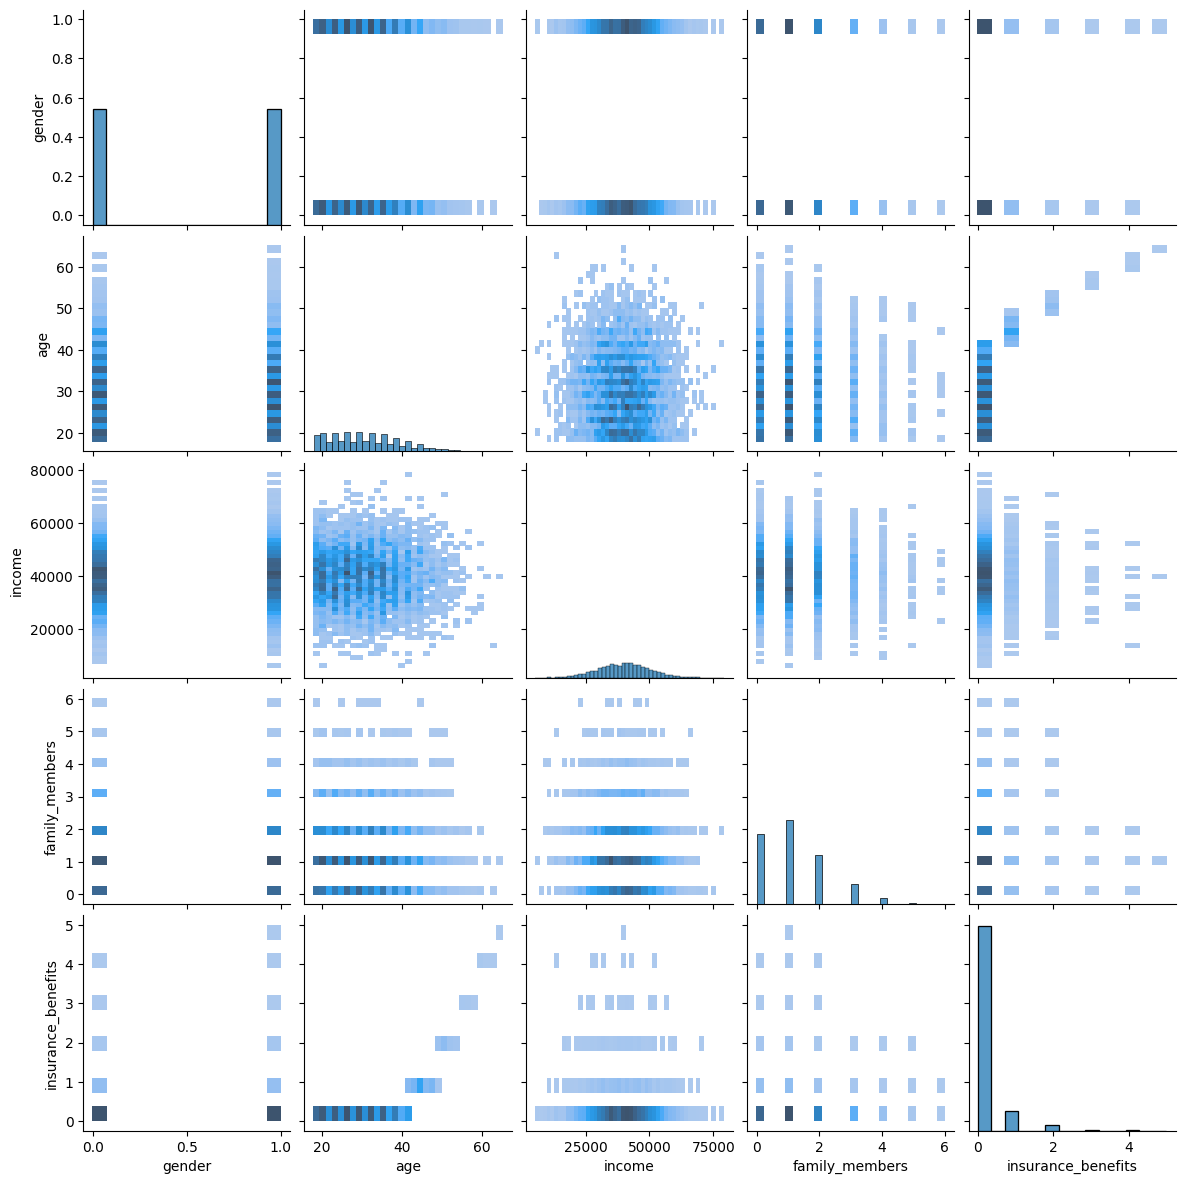

In [10]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [11]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [12]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MaxAbsScaler
import pandas as pd

def get_knn(df, n, k, metric, scale=False):
    """
    Returns k nearest neighbors for the nth object based on a specified distance metric.

    :param df: pandas DataFrame with all features except the target variable
    :param n: index for which the nearest neighbors are looked for
    :param k: the number of nearest neighbors to return
    :param metric: name of distance metric ('euclidean' or 'manhattan')
    :param scale: boolean, whether to scale the data using MaxAbsScaler
    """
    # Scale the data if needed
    if scale:
        scaler = MaxAbsScaler()
        df_scaled = scaler.fit_transform(df)
        df = pd.DataFrame(df_scaled, columns=df.columns)
    
    # Create instance of NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=k, metric=metric).fit(df)
    
    # Finding the distances and indices of the k-nearest neighbors
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n]], return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]],
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
    ], axis=1)
    
    return df_res

Scaling the data.

In [13]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [14]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
3625,1.0,0.292308,0.613924,0.333333,0
3718,0.0,0.400000,0.717722,0.000000,0
2765,1.0,0.430769,0.575949,0.000000,0
4863,0.0,0.600000,0.486076,0.333333,0
1586,1.0,0.353846,0.236709,0.166667,0


Now, let's get similar records for a given one for every combination

In [15]:
#define features
X = df.drop(columns='insurance_benefits')  

# Test combinations
combinations = [
    {'scale': False, 'metric': 'euclidean'},
    {'scale': False, 'metric': 'manhattan'},
    {'scale': True, 'metric': 'euclidean'},
    {'scale': True, 'metric': 'manhattan'},
]

# Perform tests
for combo in combinations:
    result = get_knn(X, n=0, k=5, metric=combo['metric'], scale=combo['scale'])
    print(f"Results for scale={combo['scale']} and metric={combo['metric']}:")
    print(result)
    print("\n")

Results for scale=False and metric=euclidean:
      gender  age   income  family_members  distance
0          1   41  49600.0               1  0.000000
2022       1   41  49600.0               0  1.000000
1225       0   42  49600.0               0  1.732051
4031       1   44  49600.0               2  3.162278
3424       0   38  49600.0               0  3.316625


Results for scale=False and metric=manhattan:
      gender  age   income  family_members  distance
0          1   41  49600.0               1       0.0
2022       1   41  49600.0               0       1.0
1225       0   42  49600.0               0       3.0
4031       1   44  49600.0               2       4.0
3424       0   38  49600.0               0       5.0


Results for scale=True and metric=euclidean:
      gender       age    income  family_members  distance
0        1.0  0.630769  0.627848        0.166667  0.000000
2689     1.0  0.630769  0.634177        0.166667  0.006329
133      1.0  0.615385  0.636709        0.1666

Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

The data not being scaled seems to impact the kNN algorithm significantly. Distances generated by our algorithm increase signficantly when not scaling the data. This aligns with our expectations as scaling data ensures that the features with larger ranges do not dominate our distance metric.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

Our data in Manhattan distance metrics appears to be significantly different in terms of determining distance.

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [16]:
# calculate the target

df['insurance_benefits_received'] = df['insurance_benefits'] > 0
df_scaled['insurance_benefits_received'] = df_scaled['insurance_benefits'] > 0 

In [17]:
# check for the class imbalance with value_counts()

df['insurance_benefits_received'].value_counts()

False    4436
True      564
Name: insurance_benefits_received, dtype: int64

In [18]:
X= df[['gender', 'age', 'income', 'family_members']]
y= df[['insurance_benefits_received']]
X_scaled = df_scaled[['gender', 'age', 'income', 'family_members']]
y_scaled = df_scaled[['insurance_benefits_received']]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

f1_scores_original = []
f1_scores_scaled = []
   
for k in range(1, 11):
    # Original data
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    f1_scores_original.append(f1_score(y_test, y_pred))
   
    # Scaled data
    knn.fit(X_train_scaled, y_train)
    y_pred_scaled = knn.predict(X_test_scaled)
    f1_scores_scaled.append(f1_score(y_test, y_pred_scaled))
   
print("F1 Scores for Original Data: ", f1_scores_original)
print("F1 Scores for Scaled Data: ", f1_scores_scaled)

/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

F1 Scores for Original Data:  [0.6559139784946237, 0.44755244755244755, 0.4675324675324675, 0.1935483870967742, 0.20634920634920637, 0.10434782608695652, 0.10434782608695652, 0.03603603603603604, 0.03603603603603604, 0.0]
F1 Scores for Scaled Data:  [0.9339622641509433, 0.9223300970873787, 0.9289099526066351, 0.911764705882353, 0.9383886255924171, 0.9170731707317074, 0.9282296650717704, 0.9045226130653267, 0.9365853658536586, 0.9207920792079208]


/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


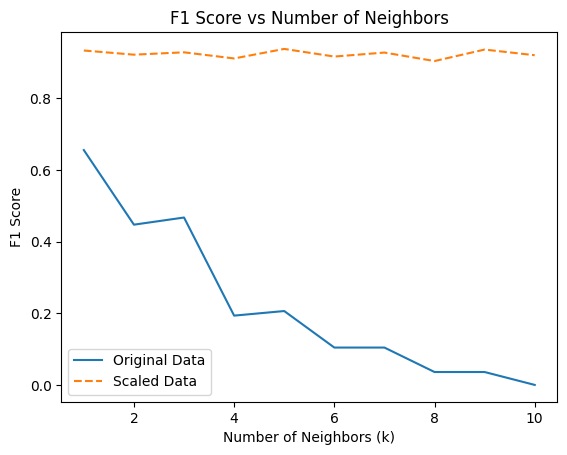

In [21]:
import matplotlib.pyplot as plt
   
plt.plot(range(1, 11), f1_scores_original, label='Original Data')
plt.plot(range(1, 11), f1_scores_scaled, label='Scaled Data', linestyle='--')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Number of Neighbors')
plt.legend()
plt.show()
   


In [22]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    

    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [23]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [24]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(df))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]

The probability: 0.50
F1: 0.20
Confusion Matrix
[[0.456  0.4312]
 [0.053  0.0598]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.     0.8872]
 [0.     0.1128]]



Conclusion:

Here we have built a kNN evaluator to test the f1 score with k values ranging from 1-10 for both our scaled and unscaled data. After that we created a dummy model for this case to see which one performs better. We can draw some conclusions from our results.

1. For unscaled data, increasing k decreases our f1 score by about 0.15 with each k added to our evaluator
2. Scaling our data seems to significantly improve our f1 scores and f1 scores with scaled data do not decrease with additional k values
3. Our highest f1 score for our best unscaled data prediction is between 0.6 and 0.7 (k=1)
4. Our highest f1 score for our best scaled data prediction is abobe 0.9 and is consistent no matter the k value
5. Our dummy model does not yield better f1 results than either our scaled or unscaled kNN evaluator.

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [25]:
class MyLinearRegression:
    def __init__(self):
        self.weights = None
    
    def fit(self, X, y):
        # Correcting the addition of ones to X
        X2 = np.append(np.ones((len(X), 1)), X, axis=1)
        # Correcting the case and removing to_numpy for y
        self.weights = np.linalg.inv(np.dot(X2.T, X2)).dot(X2.T).dot(y)

    def predict(self, X):
        # Correcting the addition of ones to X in predict method
        X2 = np.append(np.ones((len(X), 1)), X, axis=1)
        y_pred = X2.dot(self.weights)
        return y_pred

In [26]:
def eval_regressor(y_true, y_pred):
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = sklearn.metrics.r2_score(y_true, y_pred)
    print(f'R2: {r2_score:.2f}') 

In [27]:
df.head()

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
0,1,41,49600.0,1,0,False
1,0,46,38000.0,1,1,True
2,0,29,21000.0,0,0,False
3,0,21,41700.0,2,0,False
4,1,28,26100.0,0,0,False


In [28]:
lr1 = MyLinearRegression()

lr1.fit(X_train, y_train)
print(lr1.weights)

y_test_pred = lr1.predict(X_test)
eval_regressor(y_test, y_test_pred)

lr2 = MyLinearRegression()

lr2.fit(X_train_scaled, y_train_scaled)
print(lr2.weights)

y_test_scaled_pred = lr2.predict(X_test_scaled)
eval_regressor(y_test_scaled, y_test_scaled_pred)

[[-6.54335626e-01]
 [-2.13857583e-03]
 [ 2.48414312e-02]
 [ 1.33714029e-07]
 [-7.90827397e-03]]
RMSE: 0.23
R2: 0.45
[[-0.65433563]
 [-0.00213858]
 [ 1.61469303]
 [ 0.01056341]
 [-0.04744964]]
RMSE: 0.23
R2: 0.45


Conclusion:

We have created a linear regression model and tested it for RMSE values for both unscaled and scaled data. The RMSE and R2 values showed no differences between the two datasets. This is in line with our understanding of linear regression models as scaling data should not impact metrics like RMSE or R2 because scaling data uniformily doesn't change the underlying linear relationship within the data.

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [29]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [30]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [31]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [32]:
try:
    np.allclose(np.dot(P, np.linalg.inv(P)), np.eye(4))
except:
    print("Matrix P is not invertible")
else:
    inverse_P = np.linalg.inv(P)
    print('Matrix P:\n', P)
    print()
    print('Inverse Matrix P:\n', inverse_P)

Matrix P:
 [[0.77395605 0.43887844 0.85859792 0.69736803]
 [0.09417735 0.97562235 0.7611397  0.78606431]
 [0.12811363 0.45038594 0.37079802 0.92676499]
 [0.64386512 0.82276161 0.4434142  0.22723872]]

Inverse Matrix P:
 [[ 0.41467992 -1.43783972  0.62798546  1.14001268]
 [-1.06101789  0.44219337  0.1329549   1.18425933]
 [ 1.42362442  1.60461607 -2.0553823  -1.53699695]
 [-0.11128575 -0.65813802  1.74995517 -0.11816316]]


Can you guess the customers' ages or income after the transformation?

No, it is not possible to accurately guess customers' ages or income after the transformation without access to the transformation matrix ( P ) or its inverse ( P^{-1} ). Since P is randomly generated the original data cannot be easily retrieved and therefor is not available to us.

In [33]:
# Transform the data
X_transformed = np.dot(X, P)
print("Transformed data (first 5 rows):\n", X_transformed[:5])



Transformed data (first 5 rows):
 [[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 [ 5345.60393712 18803.22720286 15479.14837264 38663.06186284]
 [ 3347.17673462 11782.82928336  9699.99894205 24211.27337753]]


Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

In [34]:
# Recover the original data
X_recovered = np.dot(X_transformed, inverse_P)
print("Is the original data recovered accurately? ", np.allclose(X, X_recovered))
print("Original data (first 5 rows):\n", X[:5])
print("Transformed data (first 5 rows):\n", X_transformed[:5])
print("Recovered data (first 5 rows):\n", X_recovered[:5])

Is the original data recovered accurately?  True
Original data (first 5 rows):
 [[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 [0.00e+00 2.10e+01 4.17e+04 2.00e+00]
 [1.00e+00 2.80e+01 2.61e+04 0.00e+00]]
Transformed data (first 5 rows):
 [[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 [ 5345.60393712 18803.22720286 15479.14837264 38663.06186284]
 [ 3347.17673462 11782.82928336  9699.99894205 24211.27337753]]
Recovered data (first 5 rows):
 [[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [-4.47363596e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-2.51586878e-12  2.90000000e+01  2.10000000e+04  9.52452315e-13]
 [-4.84498208e-12  2.10000000e+01  4.17000000e+04  2.00000000e+00]
 [ 1.00000000e+00  2.80000000e+01  2.61000000e+04 -1.01990740e-13]]


Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

It's possible that the values would be slightly different after the transformation and recovery due to accumulation of rounding errors when transforming values. The more a dataset is multiplied by inverse P, the more likely these tiny errors in precision will accumulate and change the data values. Even though each individual multiplication might introduce tiny errors, when you perform two successive multiplications (first to obfuscate and then to recover), these small errors may accumulate, leading to a slight deviation from the original dataset.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

The essential idea is that under certain conditions (like (P) being orthogonal), obfuscated data does not fundamentally alter the predictive capability of a linear regression model, as the transformation is reversible and preserves linear relationships.


**Analytical proof**

Given:
[ w_P = [(XP)^T(XP)]^{-1}(XP)^Ty ]

First, rewrite ( (XP)^T(XP) ):
[ (XP)^T(XP) = P^TX^TXP ]

Thus:
[ w_P = (P^TX^TXP)^{-1}(XP)^Ty ]

By properties of matrix inversion (Appendix B), we know:
[ (P^TX^TXP)^{-1} = P^{-1}(X^TX)^{-1}(P^T)^{-1} ]

Using this, we get:
[ w_P = P^{-1}(X^TX)^{-1}(P^T)^{-1}(XP)^Ty ]

Next, simplify:
[ (XP)^Ty = P^TX^Ty ]

So now:
[ w_P = P^{-1}(X^TX)^{-1}(P^T)^{-1} P^T X^T y ]

From properties of inverses:
[ (P^T)^{-1}P^T = I ]

Thus:
[ w_P = P^{-1} (X^TX)^{-1} X^Ty ]

Since ( (X^TX)^{-1}X^Ty = w ):
[ w_P = P^{-1} w ]

#### Predicted Values:
For ( w ), predicted values are:
[ Xw ]

For ( w_P ), we have:
[ X_P w_P = XPw_P = XP(P^{-1}w) ]

Since:
[ P(P^{-1}) = I ]

We get:
[ XP(P^{-1}w) = Xw ]

Conclusion:
The predicted values using ( w ) and ( w_P ) are the same:
[ Xw = X_P w_P ]

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- <! your comment here !>
- Use $XP$ as the new feature matrix

In [35]:
#create a square matrix of random numbers
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

In [36]:
np.allclose((P.dot(np.linalg.inv(P))), np.eye(4))

True

In [37]:
from sklearn.linear_model import LinearRegression

#create matrix XP
XP_train = X_train.dot(P)
XP_test = X_test.dot(P)

#train model with obfuscated data
model = LinearRegression()
model.fit(XP_train, y_train)
y_test_pred_obfs = model.predict(XP_test)
eval_regressor(y_test, y_test_pred_obfs)

RMSE: 0.23
R2: 0.45


In [38]:
model = LinearRegression()
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
eval_regressor(y_test, y_test_pred)

RMSE: 0.23
R2: 0.45


# Conclusions

We have completed our analysis of the Sure Tomorrow Insurance Company to identify a few key observations about customer behavior:

1. We designed a model to identify potential customers that are close in behavior and demographic to current customers.
2. We designed a model to determine the probability of customers to make a purchase of insurance and increased the accuracy of our model by using scaled data. Our results were tested against a random dummy model to determine if we could significantly outperform it which our model was able to achieve.
3. We used a linear regression model to check RMSE and R2 scores of scaled and unscaled data and displayed our results.
4. We obfuscated out data by multipying our data by an inverse of P and then recovered our dataset to make sure customer data is protected without breaking our prediction model.

# Checklist

# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>